In [1]:
import kagglehub
import torch
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, ConcatDataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import tqdm as tq
import timm
import numpy as np
from torch.utils.data import Subset

/home/hhabib/.pyenv/versions/AIML/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PACS_base_path = kagglehub.dataset_download("nickfratto/pacs-dataset")

In [3]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
pacs_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

pacs_sketch_dataset = datasets.ImageFolder(root=f"{PACS_base_path}/pacs_data/pacs_data/sketch", transform=pacs_transforms)
indices = np.random.permutation(len(pacs_sketch_dataset))
pacs_sketch_dataset = Subset(pacs_sketch_dataset, indices)

pacs_photo_dataset = datasets.ImageFolder(root=f"{PACS_base_path}/pacs_data/pacs_data/photo", transform=pacs_transforms)
indices = np.random.permutation(len(pacs_photo_dataset))
pacs_photo_dataset = Subset(pacs_photo_dataset, indices)

pacs_cartoon_dataset = datasets.ImageFolder(root=f"{PACS_base_path}/pacs_data/pacs_data/cartoon", transform=pacs_transforms)
indices = np.random.permutation(len(pacs_cartoon_dataset))
pacs_cartoon_shuffled = Subset(pacs_cartoon_dataset, indices)

pacs_art_dataset = datasets.ImageFolder(root=f"{PACS_base_path}/pacs_data/pacs_data/art_painting", transform=pacs_transforms)
indices = np.random.permutation(len(pacs_art_dataset))
pacs_art_dataset = Subset(pacs_art_dataset, indices)   

In [5]:

pacs_photo_test = Subset(pacs_photo_dataset, range(50))
pacs_art_test = Subset(pacs_art_dataset, range(50))
pacs_cartoon_test = Subset(pacs_cartoon_dataset, range(50))

pacs_art_train = Subset(pacs_art_dataset, range(50, len(pacs_art_dataset)))
pacs_photo_train = Subset(pacs_photo_dataset, range(50, len(pacs_photo_dataset)))
pacs_cartoon_train = Subset(pacs_cartoon_dataset, range(50, len(pacs_cartoon_dataset)))

source_test_dataset = ConcatDataset([pacs_photo_test, pacs_art_test, pacs_cartoon_test])


train_dataset = ConcatDataset([pacs_art_train, pacs_photo_train, pacs_cartoon_train])


source_test_loader = DataLoader(source_test_dataset, batch_size=32, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
target_loader = DataLoader(pacs_sketch_dataset, batch_size=32, shuffle=True)

In [6]:
_, label = target_loader.dataset[4]
label

1

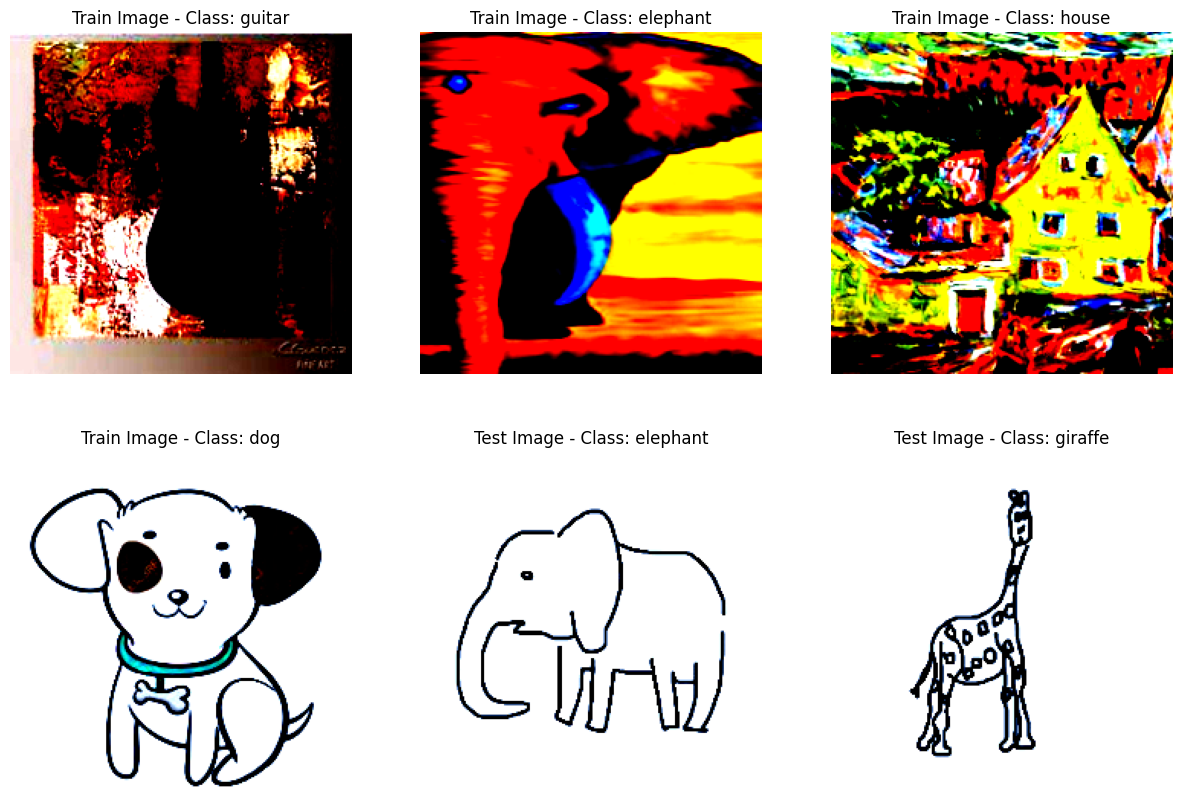

In [16]:
classes = ["dog", "elephant", "giraffe", "guitar", "horse", "house", "person"]


len_train = len(train_loader.dataset)
len_test = len(target_loader.dataset)

random_train_indices = np.random.choice(np.arange(len_train), size=4, replace=False)

random_test_indices = np.random.choice(np.arange(len_test), size=2, replace=False)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, idx in enumerate(random_train_indices):
    image, label = train_loader.dataset[idx]
    ax = axes[i // 3, i % 3]
    ax.imshow(image.permute(1, 2, 0))
    ax.set_title(f"Train Image - Class: {classes[label]}")
    ax.axis('off')

for i, idx in enumerate(random_test_indices):
    image, label = target_loader.dataset[idx]
    ax = axes[(i + 4) // 3, (i + 4) % 3]
    ax.imshow(image.permute(1, 2, 0))
    ax.set_title(f"Test Image - Class: {classes[label]}")
    ax.axis('off')


In [7]:
class Algorithm(torch.nn.Module):
    """
    A subclass of Algorithm implements a domain generalization algorithm.
    Subclasses should implement the following:
    - update()
    - predict()
    """
    def __init__(self, input_shape, num_classes, num_domains, hparams):
        super(Algorithm, self).__init__()
        self.hparams = hparams

    def update(self, minibatches, unlabeled=None):
        """
        Perform one update step, given a list of (x, y) tuples for all
        environments.

        Admits an optional list of unlabeled minibatches from the test domains,
        when task is domain_adaptation.
        """
        raise NotImplementedError

    def predict(self, x):
        raise NotImplementedError

In [8]:
class ERM(Algorithm):
    """
    Empirical Risk Minimization (ERM)
    """

    def __init__(self, input_shape, num_classes, num_domains, hparams):
        super(ERM, self).__init__(input_shape, num_classes, num_domains,
                                  hparams)
        self.featurizer = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.classifier = nn.Linear(
            self.featurizer.fc.in_features,
            num_classes)
        self.featurizer.fc = nn.Identity()


        self.network = nn.Sequential(self.featurizer, self.classifier)
        self.optimizer = torch.optim.Adam(
            self.network.parameters(),
            lr=self.hparams["lr"],
            weight_decay=self.hparams['weight_decay']
        )

        self.normalize = torch.nn.Sequential(
            # timm models expect 224x224 RGB normalized to ImageNet stats
            nn.Identity()
        )

    def update(self, minibatches, unlabeled=None):
        all_x = torch.cat([x for x, y in minibatches])
        all_y = torch.cat([y for x, y in minibatches])
        loss = F.cross_entropy(self.predict(all_x), all_y)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return {'loss': loss.item()}

    def predict(self, x):
        return self.network(x)

In [9]:
from torch import autograd

class IRM(ERM):
    """Invariant Risk Minimization"""

    def __init__(self, input_shape, num_classes, num_domains, hparams):
        super(IRM, self).__init__(input_shape, num_classes, num_domains,
                                  hparams)
        self.register_buffer('update_count', torch.tensor([0]))

    @staticmethod
    def _irm_penalty(logits, y):
        """IRM v1: More stable penalty formulation"""
        device = logits.device
        scale = torch.tensor(1.).to(device).requires_grad_()
        
        # Use the full batch, not splits (more stable)
        loss = F.cross_entropy(logits * scale, y)
        grad = autograd.grad(loss, [scale], create_graph=True)[0]
        
        # Penalty is deviation from 1.0 (optimal invariant predictor has grad=1.0)
        penalty = (grad - 1.0) ** 2
        
        return penalty

    def update(self, minibatches, unlabeled=None):
        device = "cuda" if minibatches[0][0].is_cuda else "cpu"
        penalty_weight = (self.hparams['irm_lambda'] if self.update_count
                          >= self.hparams['irm_penalty_anneal_iters'] else
                          1.0)
        nll = 0.
        penalty = 0.
        total = 0
        correct = 0
        
        # CRITICAL: Process each domain separately, not concatenated!
        for i, (x, y) in enumerate(minibatches):
            # Separate forward pass for each domain
            logits = self.network(x)
            
            nll += F.cross_entropy(logits, y)
            penalty += self._irm_penalty(logits, y)
            correct += (logits.argmax(1) == y).sum().item()
            total += len(x)

        
        accu = correct / total
        nll /= len(minibatches)
        penalty /= len(minibatches)
        loss = nll + (penalty_weight * penalty)
        
        if self.update_count == self.hparams['irm_penalty_anneal_iters']:
            self.optimizer = torch.optim.Adam(
                self.network.parameters(),
                lr=self.hparams["lr"],
                weight_decay=self.hparams['weight_decay'])
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.update_count += 1
        
        return {'loss': loss.item(), 'nll': nll.item(),
                'penalty': penalty.item(), 'accu': accu}

In [30]:
photo_loader = DataLoader(pacs_photo_train, batch_size=32, shuffle=True)
art_loader = DataLoader(pacs_art_train, batch_size=32, shuffle=True)
cartoon_loader = DataLoader(pacs_cartoon_train, batch_size=32, shuffle=True)

train_loaders = [photo_loader, art_loader, cartoon_loader]

In [31]:
hparams = {
    "lr": 1e-4,
    "weight_decay": 1e-4,
    "irm_lambda": 1000.0,
    "irm_penalty_anneal_iters": 1000
}
num_epochs = 2
irm_model = IRM(3 * 224 * 224, 7, 3, hparams).to(device)
irm_model.network = irm_model.network.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 208MB/s]


In [32]:
from tqdm import tqdm

num_epochs = 10
irm_model.train()

for epoch in range(num_epochs):
    iters = [iter(loader) for loader in train_loaders]
    steps_per_epoch = max(len(loader) for loader in train_loaders)
    
    epoch_metrics = {'loss': [], 'nll': [], 'penalty': [], 'accu': []}
    
    pbar = tqdm(range(steps_per_epoch), 
                desc=f"Epoch {epoch+1}/{num_epochs}",
                ncols=140)
    
    for step in pbar:
        minibatches = []
        
        for i, it in enumerate(iters):
            try:
                x, y = next(it)
            except StopIteration:
                iters[i] = iter(train_loaders[i])
                x, y = next(iters[i])
            
            x, y = x.to(device), y.to(device)
            minibatches.append((x, y))
        
        metrics = irm_model.update(minibatches)
        
        # Store all metrics
        for key in epoch_metrics:
            epoch_metrics[key].append(metrics[key])
        
        # Calculate running average for accuracy
        window = min(100, len(epoch_metrics['accu']))
        avg_acc = sum(epoch_metrics['accu'][-window:]) / window
        
        # Show instant values for all, averaged for accuracy
        pbar.set_postfix({
            'L': f"{metrics['loss']:.3f}",
            'NLL': f"{metrics['nll']:.3f}",
            'Pen': f"{metrics['penalty']:.3f}",
            'Acc': f"{metrics['accu']:.3f}",
            'AvgAcc': f"{avg_acc:.3f}"
        })
    
    # Epoch summary
    print(f"\nEpoch {epoch+1} - "
          f"Loss: {sum(epoch_metrics['loss'])/len(epoch_metrics['loss']):.4f}, "
          f"NLL: {sum(epoch_metrics['nll'])/len(epoch_metrics['nll']):.4f}, "
          f"Penalty: {sum(epoch_metrics['penalty'])/len(epoch_metrics['penalty']):.4f}, "
          f"Accuracy: {sum(epoch_metrics['accu'])/len(epoch_metrics['accu']):.4f}\n")

Epoch 1/10: 100%|███████████████████████████████████| 72/72 [01:33<00:00,  1.30s/it, L=1.016, NLL=0.858, Pen=0.159, Acc=0.779, AvgAcc=0.498]



Epoch 1 - Loss: 1.5459, NLL: 1.3307, Penalty: 0.2152, Accuracy: 0.4978



Epoch 2/10: 100%|███████████████████████████████████| 72/72 [01:33<00:00,  1.30s/it, L=1.022, NLL=0.401, Pen=0.621, Acc=0.826, AvgAcc=0.805]



Epoch 2 - Loss: 0.9915, NLL: 0.6895, Penalty: 0.3021, Accuracy: 0.8052



Epoch 3/10: 100%|███████████████████████████████████| 72/72 [01:33<00:00,  1.30s/it, L=0.991, NLL=0.483, Pen=0.508, Acc=0.837, AvgAcc=0.813]



Epoch 3 - Loss: 0.9771, NLL: 0.6920, Penalty: 0.2851, Accuracy: 0.8129



Epoch 4/10: 100%|███████████████████████████████████| 72/72 [01:33<00:00,  1.30s/it, L=0.843, NLL=0.584, Pen=0.259, Acc=0.860, AvgAcc=0.839]



Epoch 4 - Loss: 0.8928, NLL: 0.6182, Penalty: 0.2746, Accuracy: 0.8389



Epoch 5/10: 100%|███████████████████████████████████| 72/72 [01:34<00:00,  1.32s/it, L=0.924, NLL=0.601, Pen=0.323, Acc=0.802, AvgAcc=0.840]



Epoch 5 - Loss: 0.8927, NLL: 0.6021, Penalty: 0.2907, Accuracy: 0.8398



Epoch 6/10: 100%|███████████████████████████████████| 72/72 [01:33<00:00,  1.29s/it, L=0.841, NLL=0.511, Pen=0.330, Acc=0.872, AvgAcc=0.850]



Epoch 6 - Loss: 0.8629, NLL: 0.5940, Penalty: 0.2690, Accuracy: 0.8498



Epoch 7/10: 100%|███████████████████████████████████| 72/72 [01:33<00:00,  1.30s/it, L=0.803, NLL=0.496, Pen=0.307, Acc=0.849, AvgAcc=0.857]



Epoch 7 - Loss: 0.8479, NLL: 0.5710, Penalty: 0.2768, Accuracy: 0.8572



Epoch 8/10: 100%|███████████████████████████████████| 72/72 [01:32<00:00,  1.29s/it, L=0.811, NLL=0.608, Pen=0.203, Acc=0.872, AvgAcc=0.862]



Epoch 8 - Loss: 0.8254, NLL: 0.5651, Penalty: 0.2603, Accuracy: 0.8617



Epoch 9/10: 100%|███████████████████████████████████| 72/72 [01:32<00:00,  1.29s/it, L=0.779, NLL=0.464, Pen=0.315, Acc=0.907, AvgAcc=0.867]



Epoch 9 - Loss: 0.8124, NLL: 0.5517, Penalty: 0.2606, Accuracy: 0.8674



Epoch 10/10: 100%|██████████████████████████████████| 72/72 [01:32<00:00,  1.29s/it, L=0.767, NLL=0.466, Pen=0.301, Acc=0.895, AvgAcc=0.866]


Epoch 10 - Loss: 0.8109, NLL: 0.5532, Penalty: 0.2577, Accuracy: 0.8658



In [40]:
from tqdm import tqdm

num_epochs = 2
irm_model.train()

for epoch in range(num_epochs):
    iters = [iter(loader) for loader in train_loaders]
    steps_per_epoch = max(len(loader) for loader in train_loaders)
    
    epoch_metrics = {'loss': [], 'nll': [], 'penalty': [], 'accu': []}
    
    pbar = tqdm(range(steps_per_epoch), 
                desc=f"Epoch {epoch+1}/{num_epochs}",
                ncols=140)
    
    for step in pbar:
        minibatches = []
        
        for i, it in enumerate(iters):
            try:
                x, y = next(it)
            except StopIteration:
                iters[i] = iter(train_loaders[i])
                x, y = next(iters[i])
            
            x, y = x.to(device), y.to(device)
            minibatches.append((x, y))
        
        metrics = irm_model.update(minibatches)
        
        # Store all metrics
        for key in epoch_metrics:
            epoch_metrics[key].append(metrics[key])
        
        # Calculate running average for accuracy
        window = min(100, len(epoch_metrics['accu']))
        avg_acc = sum(epoch_metrics['accu'][-window:]) / window
        
        # Show instant values for all, averaged for accuracy
        pbar.set_postfix({
            'L': f"{metrics['loss']:.3f}",
            'NLL': f"{metrics['nll']:.3f}",
            'Pen': f"{metrics['penalty']:.3f}",
            'Acc': f"{metrics['accu']:.3f}",
            'AvgAcc': f"{avg_acc:.3f}"
        })
    
    # Epoch summary
    print(f"\nEpoch {epoch+1} - "
          f"Loss: {sum(epoch_metrics['loss'])/len(epoch_metrics['loss']):.4f}, "
          f"NLL: {sum(epoch_metrics['nll'])/len(epoch_metrics['nll']):.4f}, "
          f"Penalty: {sum(epoch_metrics['penalty'])/len(epoch_metrics['penalty']):.4f}, "
          f"Accuracy: {sum(epoch_metrics['accu'])/len(epoch_metrics['accu']):.4f}\n")

Epoch 1/2: 100%|████████████████████████████████████| 72/72 [01:34<00:00,  1.31s/it, L=0.885, NLL=0.723, Pen=0.163, Acc=0.884, AvgAcc=0.870]



Epoch 1 - Loss: 0.8001, NLL: 0.5490, Penalty: 0.2510, Accuracy: 0.8701



Epoch 2/2: 100%|██████████████████████████████████| 72/72 [01:32<00:00,  1.29s/it, L=138.543, NLL=1.264, Pen=0.137, Acc=0.849, AvgAcc=0.875]


Epoch 2 - Loss: 12.8286, NLL: 0.5769, Penalty: 0.2369, Accuracy: 0.8748



In [11]:
irm_model = torch.load("60.75__on_target_IRM.pth", weights_only=False)

In [12]:
irm_model.eval()

correct = 0
total = 0
with torch.no_grad():
    for x, y in tq.tqdm(source_test_loader):
        x, y = x.to(device), y.to(device)
        logits = irm_model.network(x)
        predicted = logits.argmax(dim=1)
        _, predicted = torch.max(logits.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
test_accuracy = 100 * correct / total

print(f"Test Accuracy on Source Domain: {test_accuracy:.2f}%")

100%|██████████| 5/5 [00:01<00:00,  4.60it/s]

Test Accuracy on Source Domain: 92.67%


In [13]:
irm_model.eval()

correct = 0
total = 0
with torch.no_grad():
    for x, y in tq.tqdm(target_loader):
        x, y = x.to(device), y.to(device)
        logits = irm_model.network(x)
        predicted = logits.argmax(dim=1)
        _, predicted = torch.max(logits.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
test_accuracy = 100 * correct / total

print(f"Test Accuracy on Source Domain: {test_accuracy:.2f}%")

100%|██████████| 123/123 [00:24<00:00,  5.09it/s]

Test Accuracy on Source Domain: 60.75%


In [14]:

pacs_photo_test = Subset(pacs_photo_dataset, range(50))
pacs_art_test = Subset(pacs_art_dataset, range(50))
pacs_cartoon_test = Subset(pacs_cartoon_dataset, range(50))

pacs_art_train = Subset(pacs_art_dataset, range(50, len(pacs_art_dataset)))
pacs_photo_train = Subset(pacs_photo_dataset, range(50, len(pacs_photo_dataset)))
pacs_cartoon_train = Subset(pacs_cartoon_dataset, range(50, len(pacs_cartoon_dataset)))

source_test_dataset = ConcatDataset([pacs_photo_test, pacs_art_test, pacs_cartoon_test])


train_dataset = ConcatDataset([pacs_art_train, pacs_photo_train, pacs_cartoon_train])


source_test_loader = DataLoader(source_test_dataset, batch_size=32, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
target_loader = DataLoader(pacs_sketch_dataset, batch_size=32, shuffle=True)

In [15]:
cartoon_test_loader = DataLoader(pacs_cartoon_test, batch_size=32, shuffle=True)
art_test_loader = DataLoader(pacs_art_test, batch_size=32, shuffle=True)
photo_test_loader = DataLoader(pacs_photo_test, batch_size=32, shuffle=True)

In [21]:
correct = 0
total = 0

with torch.no_grad():
    for x, y in tq.tqdm(cartoon_test_loader):
        x, y = x.to(device), y.to(device)
        logits = irm_model.network(x)
        _, predicted = torch.max(logits.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

100%|██████████| 2/2 [00:00<00:00,  6.27it/s]

Test Accuracy: 98.00%


In [23]:
correct = 0
total = 0

with torch.no_grad():
    for x, y in tq.tqdm(art_test_loader):
        x, y = x.to(device), y.to(device)
        logits = irm_model.network(x)
        _, predicted = torch.max(logits.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

100%|██████████| 2/2 [00:00<00:00,  6.25it/s]

Test Accuracy: 90.00%


In [24]:
correct = 0
total = 0

with torch.no_grad():
    for x, y in tq.tqdm(photo_test_loader):
        x, y = x.to(device), y.to(device)
        logits = irm_model.network(x)
        _, predicted = torch.max(logits.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

100%|██████████| 2/2 [00:00<00:00,  6.15it/s]

Test Accuracy: 90.00%


Text(0, 0.5, 'Accuracy (%)')

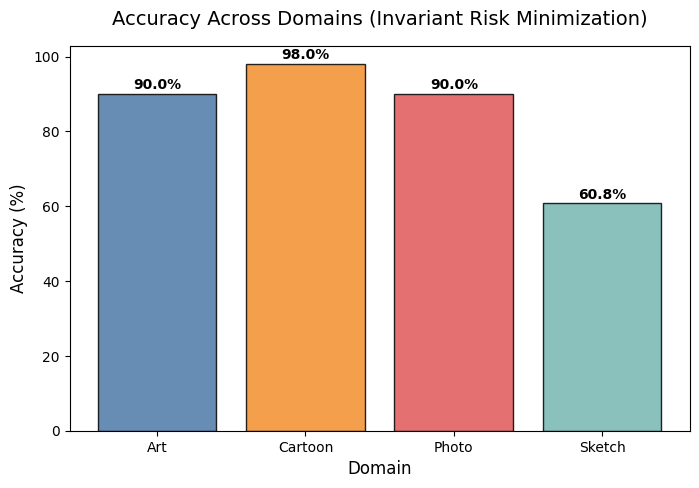

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# === Editable arrays ===
domains = ["Art", "Cartoon", "Photo", "Sketch"]  # labels for the bars
accuracies = [90.0, 98.0, 90.0, 60.75]            # accuracy values
colors = ["#4E79A7", "#F28E2B", "#E15759", "#76B7B2"]  # bar colors

# === Basic bar plot ===
plt.figure(figsize=(8, 5))
bars = plt.bar(domains, accuracies, color=colors, edgecolor="black", alpha=0.85)

# Add value labels above bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f"{acc:.1f}%", ha="center", va="bottom", fontsize=10, fontweight="bold")

# === Customization ===
plt.title("Accuracy Across Domains (Invariant Risk Minimization)", fontsize=14, pad=15)
plt.xlabel("Domain", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
